In [28]:
#import libraries
#reading data 
import pandas as pd
#data preprocessing
import re
import numpy as np
from transformers import BertModel, BertTokenizer 
import textwrap
#vector embedding 
import torch
#clustering
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
df = pd.read_csv('csv/Meeting_5_Session_3.csv')
df.head()

,Id,Session,Meeting,Speaker,Text
0,S3M51,3,5,Chairman,"Good morning, distinguished delegates. Please ..."
1,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...
2,S3M53,3,5,Chairman,I thank the distinguished representative of th...
3,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside..."
4,S3M55,3,5,Chairman,I thank the distinguished representative of Ne...


In [4]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')

 number of rows is 37


In [5]:
def chunk_text(row):
    text = row['Text']
    if len(text) > 3500:
        return textwrap.wrap(text, 3500)
    else:
        return [text]



In [6]:
#data cleaning 
def updated_text(text):
    #merge hyphanated words
    text = text.replace(' - ', '')
    #delete hyphens
    text = text.replace('-', '')
    #merge all words that have anti preceeding it with anti
    text  = re.sub(r'anti (\w+)', r'anti\1', text)
    text = text.replace('.', ' .')
    text = text.replace(',', ' ,')
    return text

In [7]:
# remove stop words from a custom list of stop words
stopwords = ['the', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 'as', 
             'what', 'which', 'this', 'that', 'these', 'those', 'then', 
             'just', 'so', 'than', 'such', 'both', 'through', 'about', 
             'for', 'is', 'of', 'while', 'during', 'to', 'What', 'Which', 
             'Is', 'If', 'While', 'This', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank', 'you','chairman.']

def remove_stopwords(text):
    #convert to lowercase
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text


In [8]:
df_updated['Text'] = df_updated.apply(chunk_text, axis=1)
df_updated = df_updated.explode('Text').reset_index(drop=True)
df_updated['cleaned_text'] = df_updated['Text'].apply(updated_text)
df_updated['cleaned_text'] = df_updated['cleaned_text'].apply(remove_stopwords)
df_updated.head()

/var/folders/5r/2zxjpss509zbfp38213y6wv00000gn/T/ipykernel_723/4252244400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated['Text'] = df_updated.apply(chunk_text, axis=1)


,Id,Session,Meeting,Speaker,Text,cleaned_text
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b..."
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg..."
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a..."


In [9]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can replace it with any other BERT model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [10]:
# Function to generate contextual embeddings
def generate_contextual_embedding(text):
    # Tokenize input text
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
    # Generate contextual embeddings
    with torch.no_grad():
        outputs = model(input_ids)
        # Extract contextual embeddings from the last layer
        last_hidden_states = outputs.last_hidden_state
    # Average pooling over tokens to get a single vector representation
    contextual_embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
    return contextual_embedding


In [11]:
# Compute contextual embeddings for each document
df_updated['contextual_embedding'] = df_updated['cleaned_text'].apply(generate_contextual_embedding)


In [12]:
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...,"[-0.35218367, 0.17405602, 0.44900993, -0.10542..."
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...,"[-0.30835244, 0.061460797, 0.24975899, -0.1546..."
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b...","[-0.21464926, 0.27779922, 0.41761667, 0.010075..."
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg...","[-0.15198769, 0.223905, 0.5595103, 0.004948167..."
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a...","[-0.39602536, 0.17177016, 0.42725387, 0.078603..."


In [13]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (norm_vector1 * norm_vector2)
    return cosine_similarity


In [15]:
# Compute cosine similarity matrix
contextual_embeddings = np.stack(df_updated['contextual_embedding'].to_numpy())
cosine_sim_matrix = np.array([[cosine_similarity(embedding1, embedding2) for embedding2 in contextual_embeddings] for embedding1 in contextual_embeddings])


In [36]:
# Perform Spectral Clustering
n_clusters = 5
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
cluster_labels = spectral_clustering.fit_predict(cosine_sim_matrix)



In [37]:
# Add cluster labels to the original DataFrame
df_updated['cluster_label'] = cluster_labels
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding,cluster_label
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...,"[-0.35218367, 0.17405602, 0.44900993, -0.10542...",3
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...,"[-0.30835244, 0.061460797, 0.24975899, -0.1546...",4
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b...","[-0.21464926, 0.27779922, 0.41761667, 0.010075...",3
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg...","[-0.15198769, 0.223905, 0.5595103, 0.004948167...",3
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a...","[-0.39602536, 0.17177016, 0.42725387, 0.078603...",2


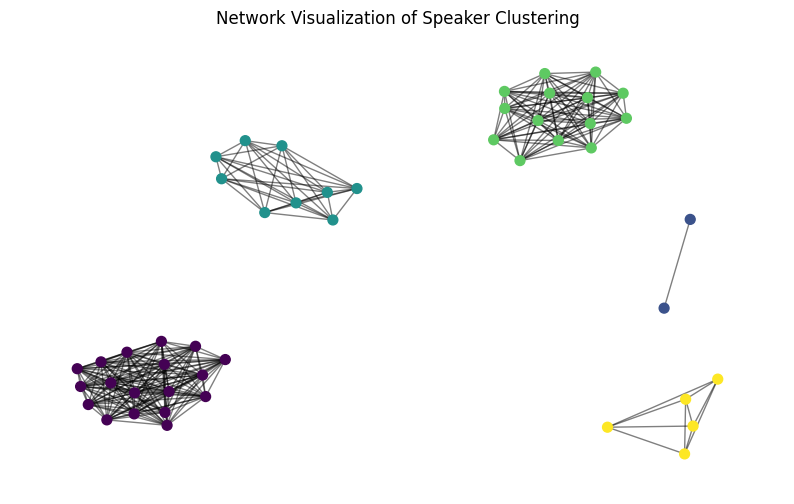

In [51]:

# Create a network graph
G = nx.Graph()

# Add nodes for each document with cluster label as node attribute
for index, row in df_updated.iterrows():
    G.add_node(index, cluster_label=row['cluster_label'])

# Add edges between documents belonging to the same cluster
for cluster_id in range(n_clusters):
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    for i, row1 in cluster_data.iterrows():
        for j, row2 in cluster_data.iterrows():
            if i != j:
                G.add_edge(i, j)

# Draw the network graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.64) 
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.viridis, node_color=cluster_labels)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Network Visualization of Speaker Clustering')
plt.axis('off')
plt.show()

